In [324]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

## Plotting

# Process Data

In [325]:
# Read in data 
root_dir = Path().resolve().parents[1]
data_dir = root_dir / "data" / "02-clean"

met_fpath = data_dir / "combined-sites.csv"
clc_fpath = data_dir / "sites-clc.csv"

met_df = pd.read_csv(met_fpath, index_col='Unnamed: 0')
clc_df = pd.read_csv(clc_fpath, index_col='Unnamed: 0')

# Preprocess
met_df['time (PST)'] = pd.to_datetime(met_df['time (PST)'])
clc_df['time-PDT'] = pd.to_datetime(clc_df['time-PDT'])

clc_df['time (PST)'] = clc_df['time-PDT'] - pd.Timedelta(hours=1) # Change PDT to PST
clc_df.drop('time-PDT', axis=1, inplace=True)

# Create derived variables
met_df['fog-binary'] = met_df['fog'].apply(lambda x: 1 if x > 0 else 0)
met_df['weather'] = met_df.apply(lambda row: 
                                 'both' if row['rain (mm)'] > 0 and row['fog'] > 0 else
                                 'rain' if row['rain (mm)'] > 0 else
                                 'fog' if row['fog'] > 0 else
                                 'none', axis=1)

rh_threshold = 98
met_df['rh-fog'] = met_df['relative humidity (%)'].apply(lambda x: 1 if x > rh_threshold else 0)

In [326]:
# Create joined multi-index dataframe
clc_df.set_index(['site', 'time (PST)'], inplace=True)
met_df.set_index(['site', 'time (PST)'], inplace=True)

df = met_df.join(clc_df, how='inner')
df.head()

fog  air temperature (C)  relative humidity (%)  \
site time (PST)                                                             
wrdg 2004-05-01 06:00:00  0.0            13.770000              60.400002   
     2004-05-01 06:30:00  0.0            14.400000              67.099998   
     2004-05-01 07:00:00  0.0            14.850000              76.000000   
     2004-05-01 07:30:00  0.0            15.710000              77.500000   
     2004-05-01 08:00:00  0.0            17.139999              71.599998   

                          wind speed (m/s)  wind gust (m/s)  \
site time (PST)                                               
wrdg 2004-05-01 06:00:00               NaN              NaN   
     2004-05-01 06:30:00               NaN              NaN   
     2004-05-01 07:00:00               NaN              NaN   
     2004-05-01 07:30:00               NaN              NaN   
     2004-05-01 08:00:00               NaN              NaN   

                          wind direction (deg)  rain (mm)  \
site time (PST)                                             
wrdg 2004-05-01 06:00:00                   NaN        0.0   
     2004-05-01 06:30:00                   NaN        0.0   
     2004-05-01 07:00:00                   NaN        0.0   
     2004-05-01 07:30:00                   NaN        0.0   
     2004-05-01 08:00:00                   NaN        0.0   

                          par (micromol/m2/s)  dew point (C)  leaf wetness  \
site time (PST)                                                              
wrdg 2004-05-01 06:00:00            196.30000           6.18        2.1442   
     2004-05-01 06:30:00            408.79999           8.45        2.1429   
     2004-05-01 07:00:00            631.29999          10.67        2.1637   
     2004-05-01 07:30:00            851.29999          11.70        2.1381   
     2004-05-01 08:00:00           1061.30000          11.97        2.2174   

                          ...  atm pressure (mb)  leaf wetness (mv)  \
site time (PST)           ...                                         
wrdg 2004-05-01 06:00:00  ...                NaN                NaN   
     2004-05-01 06:30:00  ...                NaN                NaN   
     2004-05-01 07:00:00  ...                NaN                NaN   
     2004-05-01 07:30:00  ...                NaN                NaN   
     2004-05-01 08:00:00  ...                NaN                NaN   

                          solar radiation (wm2)  atm pressure (kpa)  \
site time (PST)                                                       
wrdg 2004-05-01 06:00:00                    NaN                 NaN   
     2004-05-01 06:30:00                    NaN                 NaN   
     2004-05-01 07:00:00                    NaN                 NaN   
     2004-05-01 07:30:00                    NaN                 NaN   
     2004-05-01 08:00:00                    NaN                 NaN   

                          leaf wetness (%)  fog-binary  weather  rh-fog  \
site time (PST)                                                           
wrdg 2004-05-01 06:00:00               NaN           0     none       0   
     2004-05-01 06:30:00               NaN           0     none       0   
     2004-05-01 07:00:00               NaN           0     none       0   
     2004-05-01 07:30:00               NaN           0     none       0   
     2004-05-01 08:00:00               NaN           0     none       0   

                          cldalb cld-binary  
site time (PST)                              
wrdg 2004-05-01 06:00:00   10.39          1  
     2004-05-01 06:30:00    4.75          0  
     2004-05-01 07:00:00    3.65          0  
     2004-05-01 07:30:00    6.03          0  
     2004-05-01 08:00:00    4.94          0  

[5 rows x 23 columns]

# Data Quality Checks

## RH = 0
There's a high density of relative humidity observations at 0 which should be checked. While low RH is expected at some sites, I would expect that the RH would be more evenly distributed across low values, rather than seeing a spike at 0. 

Most of the observations where rh = 0 are at relatively low tempearture (60-77F), which seems unlikely.

There's 3 rows where RH = 0 and fog drip > 0. This isn't possible. I chose to remove all observations where RH is 0 because they're a minority of observations and doing so doesn't throw away any fog data. 

In [327]:
df_0rh = df.loc[df['relative humidity (%)'] == 0]
print(df_0rh.shape)
df_0rh.describe()

(2662, 23)


,fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),leaf wetness,...,solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,rh-fog,cldalb,cld-binary
count,2662.000000,2661.000000,2662.0,2662.000000,2662.000000,2662.000000,2662.0,2662.000000,0.0,2662.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2662.000000,2662.0,2655.000000,2662.000000
mean,0.000902,20.709335,0.0,2.566033,4.529207,189.082832,0.0,1414.302439,NaN,1.975169,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001127,0.0,7.048547,0.158527
std,0.039146,5.166573,0.0,1.532412,2.155726,127.166086,0.0,591.971026,NaN,0.323542,...,NaN,NaN,NaN,NaN,NaN,NaN,0.033558,0.0,11.210556,0.365303
min,0.000000,7.430000,0.0,0.000000,0.000000,0.000000,0.0,18.799999,NaN,0.148300,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000
25%,0.000000,16.379999,0.0,1.480000,3.150000,39.299999,0.0,926.299990,NaN,2.056300,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,2.240000,0.000000
50%,0.000000,20.190001,0.0,2.230000,4.270000,287.799990,0.0,1541.300000,NaN,2.081900,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,3.430000,0.000000
75%,0.000000,24.790001,0.0,3.530000,5.570000,297.600010,0.0,1938.800000,NaN,2.083100,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,5.750000,0.000000
max,2.000000,35.700001,0.0,9.280000,15.030000,355.200010,0.0,2326.300000,NaN,2.100200,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,78.190000,1.000000


In [328]:
df_0rh.loc[df_0rh['fog'] > 0]

fog  air temperature (C)  relative humidity (%)  \
site time (PST)                                                             
crak 2006-05-21 07:30:00  0.2                14.09                    0.0   
     2006-05-21 17:30:00  2.0                14.09                    0.0   
     2006-05-26 07:00:00  0.2                12.16                    0.0   

                          wind speed (m/s)  wind gust (m/s)  \
site time (PST)                                               
crak 2006-05-21 07:30:00              0.74             3.34   
     2006-05-21 17:30:00              1.11             5.57   
     2006-05-26 07:00:00              3.15             5.57   

                          wind direction (deg)  rain (mm)  \
site time (PST)                                             
crak 2006-05-21 07:30:00             78.599998        0.0   
     2006-05-21 17:30:00             95.500000        0.0   
     2006-05-26 07:00:00            308.899990        0.0   

                          par (micromol/m2/s)  dew point (C)  leaf wetness  \
site time (PST)                                                              
crak 2006-05-21 07:30:00           171.300000            NaN        1.2506   
     2006-05-21 17:30:00            18.799999            NaN        1.4349   
     2006-05-26 07:00:00           646.299990            NaN        0.3412   

                          ...  atm pressure (mb)  leaf wetness (mv)  \
site time (PST)           ...                                         
crak 2006-05-21 07:30:00  ...                NaN                NaN   
     2006-05-21 17:30:00  ...                NaN                NaN   
     2006-05-26 07:00:00  ...                NaN                NaN   

                          solar radiation (wm2)  atm pressure (kpa)  \
site time (PST)                                                       
crak 2006-05-21 07:30:00                    NaN                 NaN   
     2006-05-21 17:30:00                    NaN                 NaN   
     2006-05-26 07:00:00                    NaN                 NaN   

                          leaf wetness (%)  fog-binary  weather  rh-fog  \
site time (PST)                                                           
crak 2006-05-21 07:30:00               NaN           1      fog       0   
     2006-05-21 17:30:00               NaN           1      fog       0   
     2006-05-26 07:00:00               NaN           1      fog       0   

                          cldalb cld-binary  
site time (PST)                              
crak 2006-05-21 07:30:00   60.27          1  
     2006-05-21 17:30:00   41.16          1  
     2006-05-26 07:00:00    5.68          0  

[3 rows x 23 columns]

In [329]:
df = df.loc[df['relative humidity (%)'] != 0]

## Rain / Fog Comparison
How often does rain occur, and does fog typically co-occur? 

There are only 312 observations where rain > 0. For all of them, there are low clouds per the CLC threshold, as expected. 

Around a third of the observations have fog drip > 0. All rain events were removed because rain is exceedingly rare in the summer and it's not possible to disentangle rain from fog when they co-occur. Relative humidity 

In [330]:
rain_df = df.loc[df['rain (mm)'] > 0]
print("Number of observations with rian > 0:", rain_df.shape[0])
print("Number of observations with rain > 0 and CLC = True:", rain_df.loc[rain_df['cldalb'] > 0].shape[0])
rain_df.describe()

Number of observations with rian > 0: 312
Number of observations with rain > 0 and CLC = True: 311


,fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),dew point (C),leaf wetness,...,solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,rh-fog,cldalb,cld-binary
count,312.000000,312.000000,312.000000,205.000000,195.000000,195.000000,312.000000,54.000000,54.000000,80.000000,...,72.000000,0.0,0.0,0.0,0.0,0.0,312.000000,312.000000,311.000000,312.000000
mean,2.992113,12.935936,94.819679,1.657795,3.122103,238.112257,0.353431,375.281477,12.241852,1.282651,...,0.149139,NaN,NaN,NaN,NaN,NaN,0.330128,0.564103,43.807652,0.858974
std,13.278999,2.837775,10.120266,1.270466,1.857180,89.561208,0.520800,406.944006,4.671642,0.582270,...,0.164950,NaN,NaN,NaN,NaN,NaN,0.471014,0.496670,21.415668,0.348607
min,0.000000,6.273000,12.250000,0.000000,0.000000,0.000000,0.100000,13.800000,-10.820000,0.372900,...,0.005000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.110000,0.000000
25%,0.000000,11.589750,94.787500,0.852000,1.751000,164.349995,0.100400,134.425000,11.885000,0.831875,...,0.051250,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,30.090000,1.000000
50%,0.000000,13.280000,98.350000,1.480000,2.912000,283.100010,0.200000,275.049990,13.280000,1.069950,...,0.090000,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,50.650000,1.000000
75%,1.050000,14.090000,100.000000,2.222000,4.450000,300.750005,0.301190,430.049990,14.210000,2.073025,...,0.196750,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,60.175000,1.000000
max,174.420000,24.920000,100.000000,6.490000,9.460000,355.200010,5.401000,1813.800000,15.870000,2.092900,...,0.933000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,86.300000,1.000000


In [331]:
print("Number of observations where rain > 0 and fog > 0: ", rain_df.loc[rain_df['fog'] > 0].shape[0])

# Remove observations where rain > 0
df = df.loc[df['rain (mm)'] == 0]

Number of observations where rain > 0 and fog > 0:  103


# Aggregated Sites Analysis

In [332]:
df_flat = df.reset_index()
df_flat.head()

,site,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),par (micromol/m2/s),...,atm pressure (mb),leaf wetness (mv),solar radiation (wm2),atm pressure (kpa),leaf wetness (%),fog-binary,weather,rh-fog,cldalb,cld-binary
0,wrdg,2004-05-01 06:00:00,0.0,13.770000,60.400002,NaN,NaN,NaN,0.0,196.30000,...,NaN,NaN,NaN,NaN,NaN,0,none,0,10.39,1
1,wrdg,2004-05-01 06:30:00,0.0,14.400000,67.099998,NaN,NaN,NaN,0.0,408.79999,...,NaN,NaN,NaN,NaN,NaN,0,none,0,4.75,0
2,wrdg,2004-05-01 07:00:00,0.0,14.850000,76.000000,NaN,NaN,NaN,0.0,631.29999,...,NaN,NaN,NaN,NaN,NaN,0,none,0,3.65,0
3,wrdg,2004-05-01 07:30:00,0.0,15.710000,77.500000,NaN,NaN,NaN,0.0,851.29999,...,NaN,NaN,NaN,NaN,NaN,0,none,0,6.03,0
4,wrdg,2004-05-01 08:00:00,0.0,17.139999,71.599998,NaN,NaN,NaN,0.0,1061.30000,...,NaN,NaN,NaN,NaN,NaN,0,none,0,4.94,0


## Counts of Fog/Cloud Events

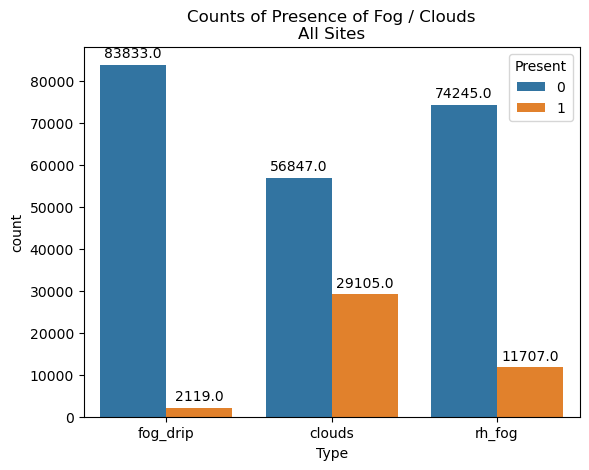

In [333]:
fog_drip_counts = df_flat['fog-binary'].value_counts()
cld_bin_counts = df_flat['cld-binary'].value_counts()
rh_fog_counts = df_flat['rh-fog'].value_counts()

count_df = pd.DataFrame({'fog_drip' : fog_drip_counts,
                         'clouds' : cld_bin_counts,
                         'rh_fog' : rh_fog_counts})
count_df = count_df.reset_index().melt(id_vars='index', var_name='category', value_name='count')

fig, ax = plt.subplots()
sns.barplot(count_df,
            x='category',
            y='count',
            hue='index',
            ax=ax)
ax.set(title='Counts of Presence of Fog / Clouds\nAll Sites',
       xlabel='Type')
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)
plt.legend(title='Present')
plt.show()

## Variable Distributions

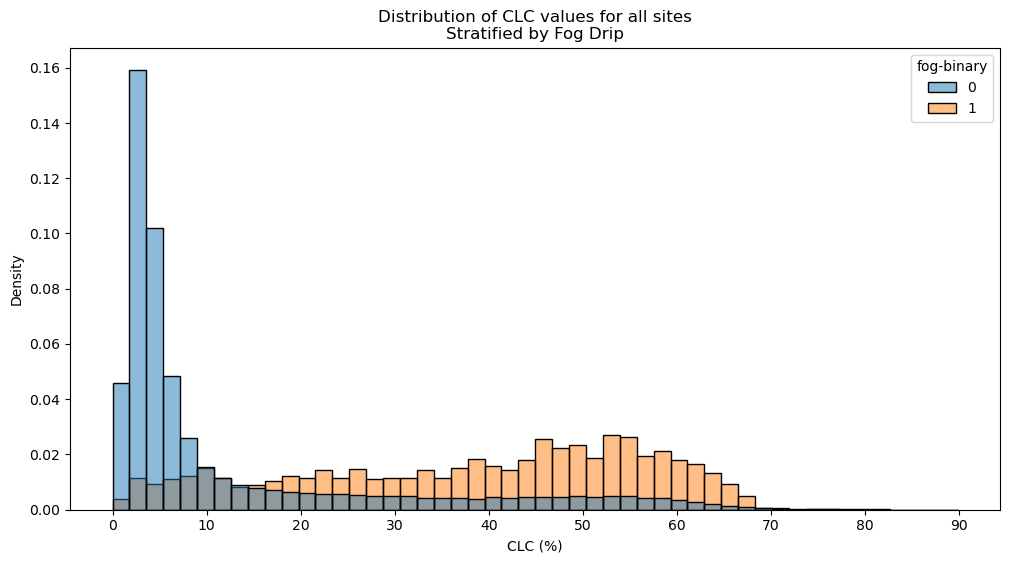

In [334]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='cldalb',
             hue='fog-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set_xticks(xticks, labels=xticks)
ax.set(title=f'Distribution of CLC values for all sites\nStratified by Fog Drip',
       xlabel='CLC (%)',)
plt.show()

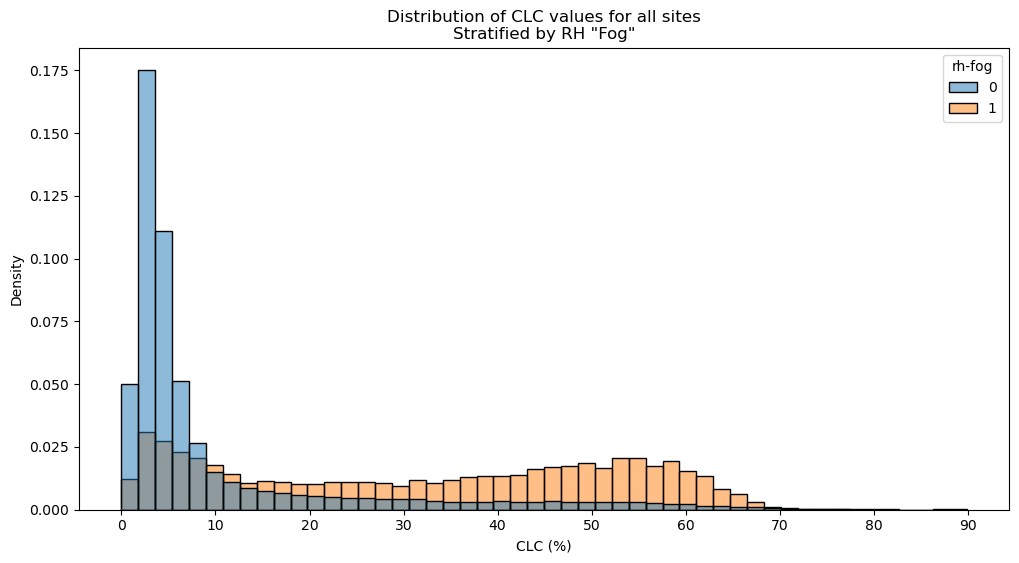

In [335]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='cldalb',
             hue='rh-fog',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set_xticks(xticks, labels=xticks)
ax.set(title=f'Distribution of CLC values for all sites\nStratified by RH "Fog"',
       xlabel='CLC (%)',)
plt.show()

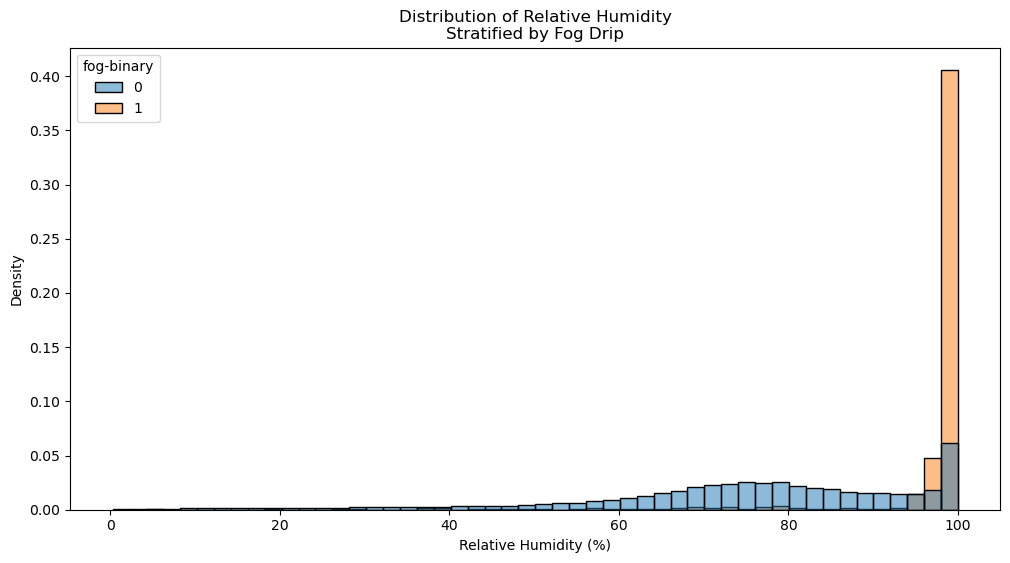

In [364]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='relative humidity (%)',
             hue='fog-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set(title=f'Distribution of Relative Humidity\nStratified by Fog Drip',
       xlabel='Relative Humidity (%)')


plt.show()

## Confusion Matrices

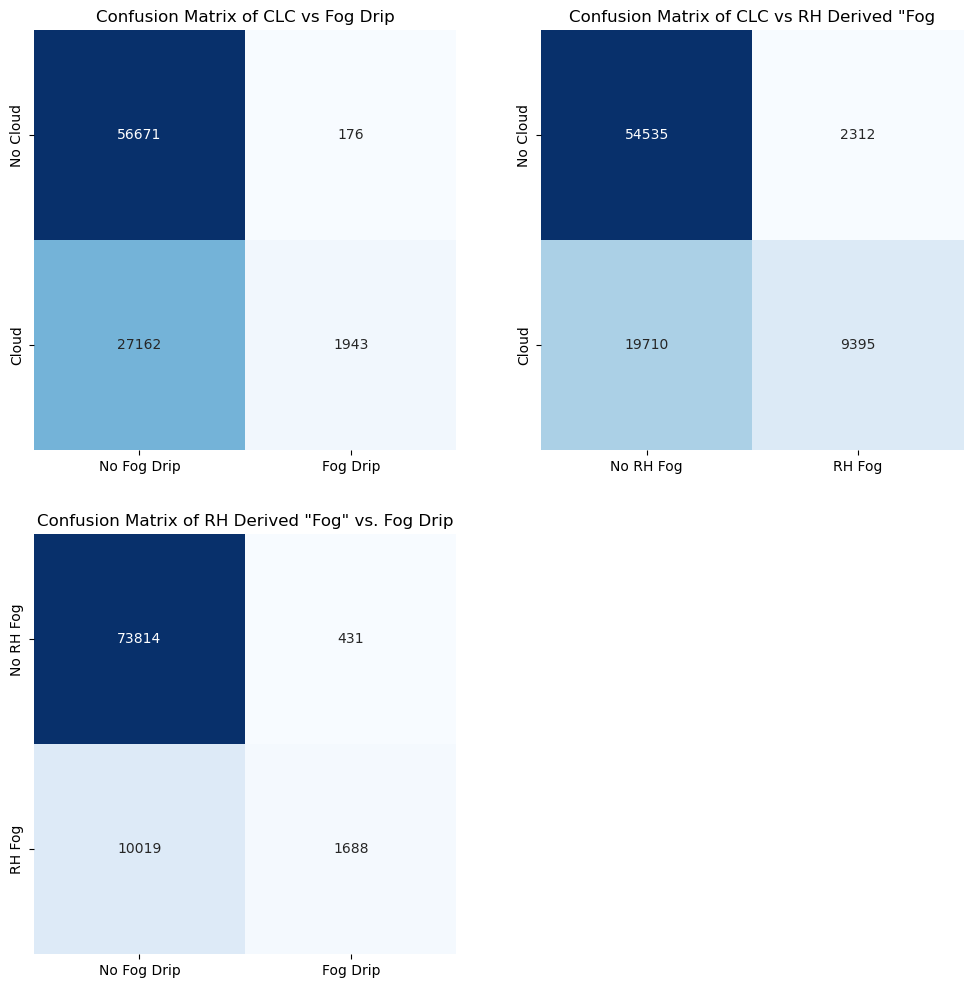

In [337]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
cm = confusion_matrix(df_flat['cld-binary'], df_flat['fog-binary'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog Drip', 'Fog Drip'], yticklabels=['No Cloud', 'Cloud'], ax=ax[0,0])
ax[0,0].set(title='Confusion Matrix of CLC vs Fog Drip')

cm = confusion_matrix(df_flat['cld-binary'], df_flat['rh-fog'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No RH Fog', 'RH Fog'], yticklabels=['No Cloud', 'Cloud'], ax=ax[0,1])
ax[0,1].set(title='Confusion Matrix of CLC vs RH Derived "Fog')

cm = confusion_matrix(df_flat['rh-fog'], df_flat['fog-binary'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog Drip', 'Fog Drip'], yticklabels=['No RH Fog', 'RH Fog'], ax=ax[1,0])
ax[1, 0].set(title='Confusion Matrix of RH Derived "Fog" vs. Fog Drip')

ax[1,1].set_axis_off()


# Show the plot
plt.show()

## Scatterplots - CLC vs. RH

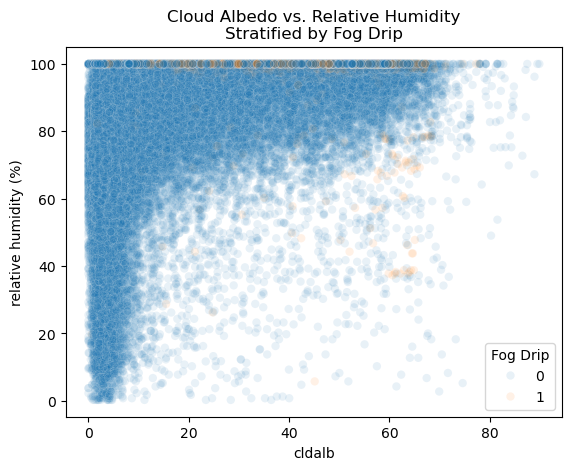

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=df_flat,
                x='cldalb',
                y='relative humidity (%)',
                hue='fog-binary',
                alpha=0.1,
                ax=ax)
ax.set(title='Cloud Albedo vs. Relative Humidity\nStratified by Fog Drip')
plt.legend(title='Fog Drip')
plt.show()

[Text(0.5, 1.0, 'Cloud Albedo vs. Relative Humidity\nFog Drip > 0')]

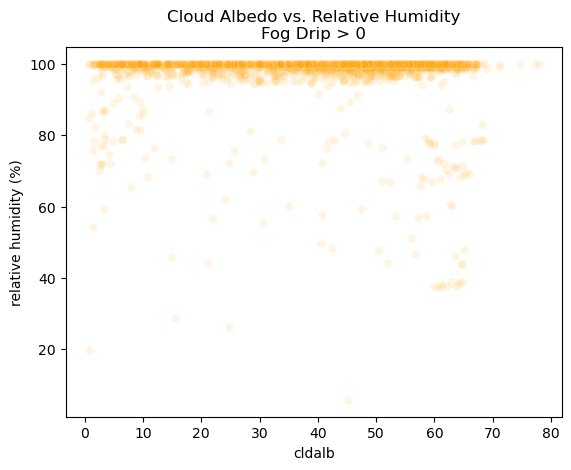

In [ ]:
fig, ax = plt.subplots()
df_fog_drip = df_flat.loc[df_flat['fog'] > 0]
sns.scatterplot(df_fog_drip,
                x='cldalb',
                y='relative humidity (%)',
                color='orange',
                alpha=0.1,
                ax=ax)
ax.set(title='Cloud Albedo vs. Relative Humidity\nFog Drip > 0')
plt.show()

## Relationship between RH and Fog Drip

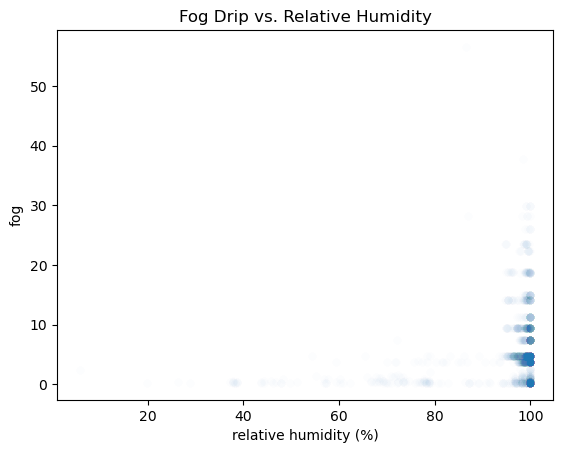

In [397]:
fig, ax = plt.subplots()
sns.scatterplot(data=df_fog_drip, 
                x='relative humidity (%)',
                y='fog',
                alpha=0.01,
                ax=ax)
ax.set(title='Fog Drip vs. Relative Humidity')
plt.show()

## Cluster Analysis

# Single site analysis  

In [340]:
df.index.get_level_values('site').unique()

Index(['wrdg', 'sauc', 'cpin', 'crak', 'crat', 'erdg', 'cair', 'upem'], dtype='object', name='site')

In [341]:
# Subselect by site and drop empty rows/columns
site = 'sauc'
site_df = df.loc[site]
site_df = site_df.dropna(axis=1, how='all')
site_df = site_df.dropna(axis=0, how='all')
site_df.head()

,fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips,fog-binary,weather,rh-fog,cldalb,cld-binary
time (PST),,,,,,,,,,,,,
2004-05-01 06:00:00,0.0,15.29,50.25,0.84,1.97,115.12,0.0,0.0,0,none,0,9.79,1
2004-05-01 06:30:00,0.0,17.19,46.23,0.56,1.38,147.98,0.0,0.0,0,none,0,5.13,0
2004-05-01 07:00:00,0.0,16.63,49.17,0.20,0.53,303.53,0.0,0.0,0,none,0,4.86,0
2004-05-01 07:30:00,0.0,19.32,44.36,1.15,1.41,157.90,0.0,0.0,0,none,0,2.85,0
2004-05-01 08:00:00,0.0,20.16,44.62,0.50,1.65,168.73,0.0,0.0,0,none,0,3.97,0


In [342]:
# Get rid of duplicates - for Sauces they were only in 2011
print("Number of duplicate indices:", site_df.index.duplicated().sum())
site_df = site_df[~site_df.index.duplicated(keep='first')]

Number of duplicate indices: 4219


In [343]:
# Check NaN counts
site_df.isna().sum()

fog                         0
air temperature (C)         0
relative humidity (%)       0
wind speed (m/s)         1413
wind gust (m/s)          1413
wind direction (deg)     1413
rain (mm)                   0
fog tips                    0
fog-binary                  0
weather                     0
rh-fog                      0
cldalb                     50
cld-binary                  0
dtype: int64

In [344]:
# NAs tend to occur at later hours when the GOES CLC algorithm is less effective, drop these few NaNs
site_df = site_df.dropna(subset='cldalb')

In [345]:
# Check timeframe
print(site_df.index.min())
print(site_df.index.max())

2004-05-01 06:00:00
2011-09-30 17:00:00


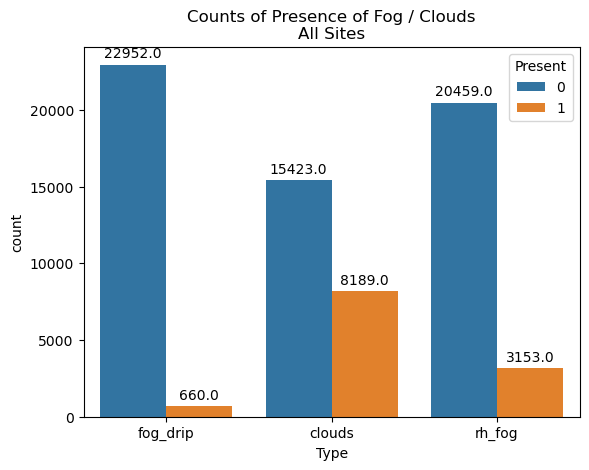

In [360]:
fog_drip_counts = site_df['fog-binary'].value_counts()
cld_bin_counts = site_df['cld-binary'].value_counts()
rh_fog_counts = site_df['rh-fog'].value_counts()

count_df = pd.DataFrame({'fog_drip' : fog_drip_counts,
                         'clouds' : cld_bin_counts,
                         'rh_fog' : rh_fog_counts})
count_df = count_df.reset_index().melt(id_vars='index', var_name='category', value_name='count')

fig, ax = plt.subplots()
sns.barplot(count_df,
            x='category',
            y='count',
            hue='index',
            ax=ax)
ax.set(title='Counts of Presence of Fog / Clouds\nAll Sites',
       xlabel='Type')
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)
plt.legend(title='Present')
plt.show()

In [348]:
df.index.get_level_values('site').unique()

Index(['wrdg', 'sauc', 'cpin', 'crak', 'crat', 'erdg', 'cair', 'upem'], dtype='object', name='site')

## Variable Distributions

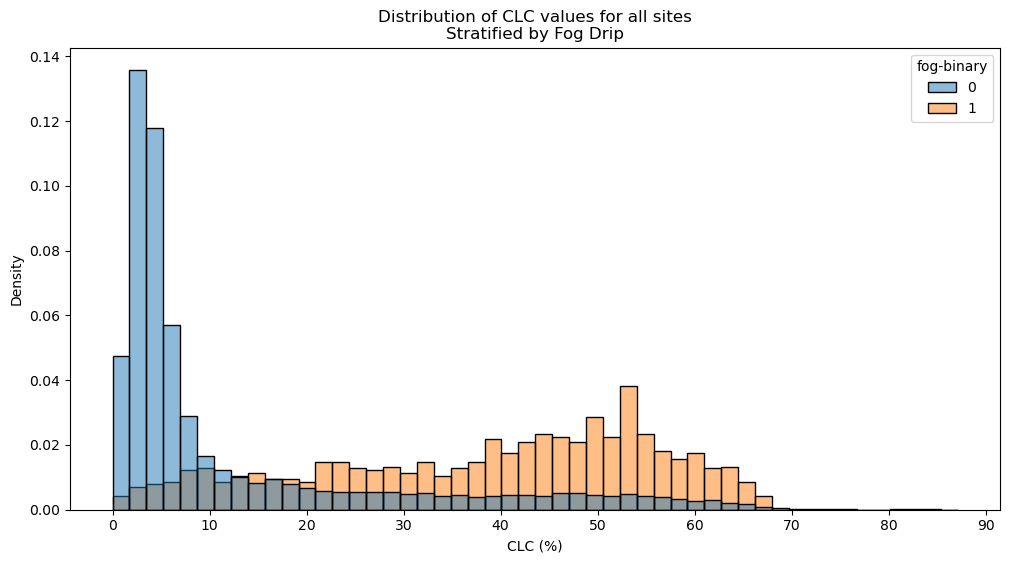

In [361]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=site_df,
             x='cldalb',
             hue='fog-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set_xticks(xticks, labels=xticks)
ax.set(title=f'Distribution of CLC values for all sites\nStratified by Fog Drip',
       xlabel='CLC (%)',)
plt.show()

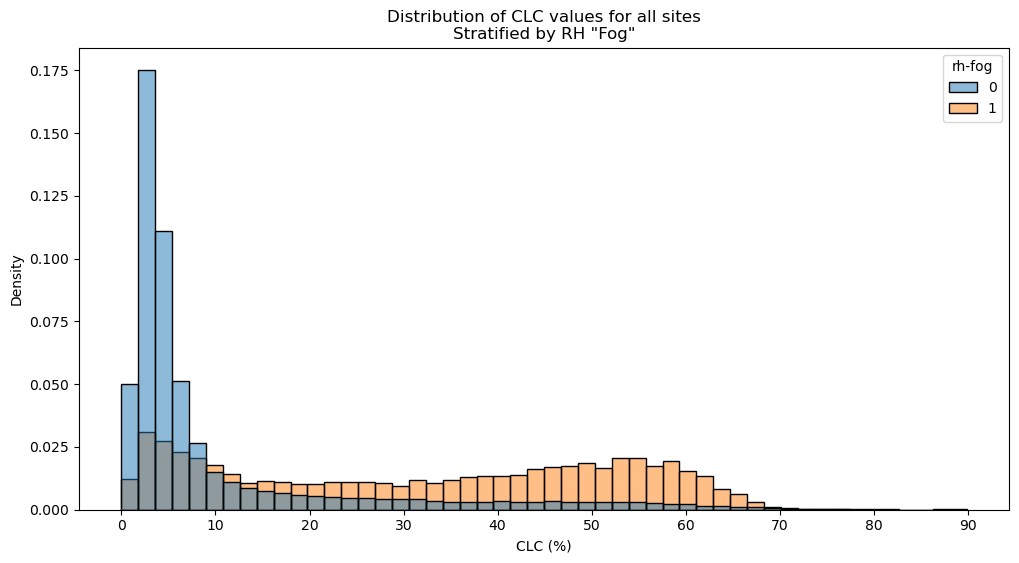

In [362]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='cldalb',
             hue='rh-fog',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set_xticks(xticks, labels=xticks)
ax.set(title=f'Distribution of CLC values for all sites\nStratified by RH "Fog"',
       xlabel='CLC (%)',)
plt.show()

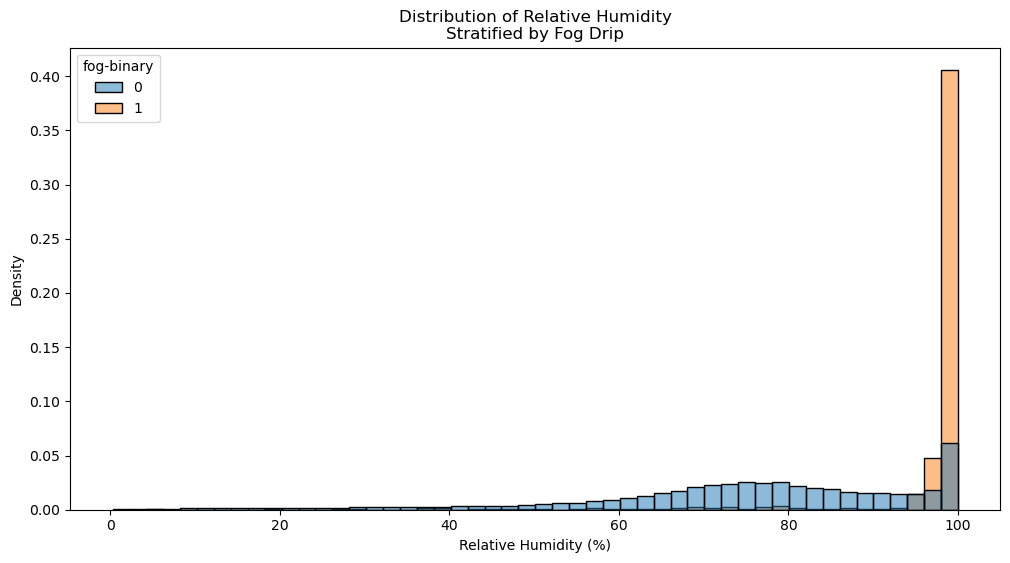

In [ ]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='relative humidity (%)',
             hue='fog-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set(title=f'Distribution of Relative Humidity\nStratified by Fog Drip',
       xlabel='Relative Humidity (%)')


plt.show()


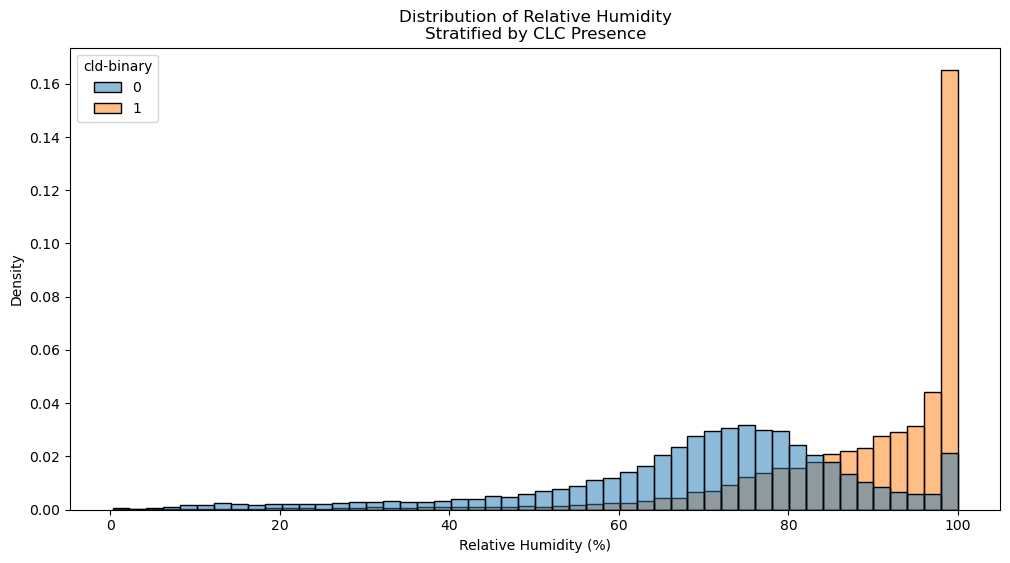

In [366]:
# Histogram of cldalb values
fig, ax = plt.subplots(figsize=(12, 6))
xticks = np.arange(0, 100, 10)

bins=50
sns.histplot(data=df_flat,
             x='relative humidity (%)',
             hue='cld-binary',
             stat='density',
             common_norm=False,
             bins=bins)
ax.set(title=f'Distribution of Relative Humidity\nStratified by CLC Presence',
       xlabel='Relative Humidity (%)')


plt.show()


## Correlation Matrix

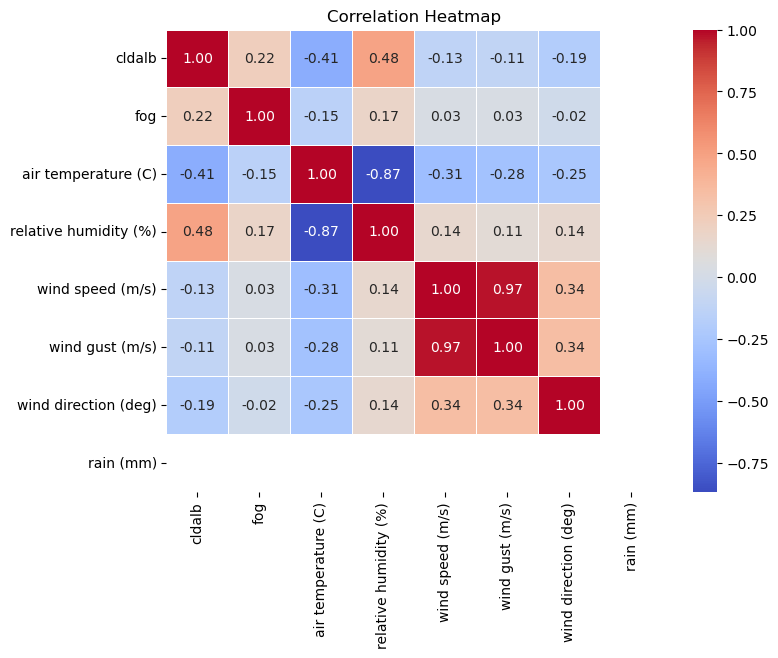

In [367]:
# Calculate the correlation matrix
corr_matrix = site_df[['cldalb', 'fog', 'air temperature (C)', 'relative humidity (%)',
       'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)',
       'rain (mm)']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Fog/LCL Agreeance

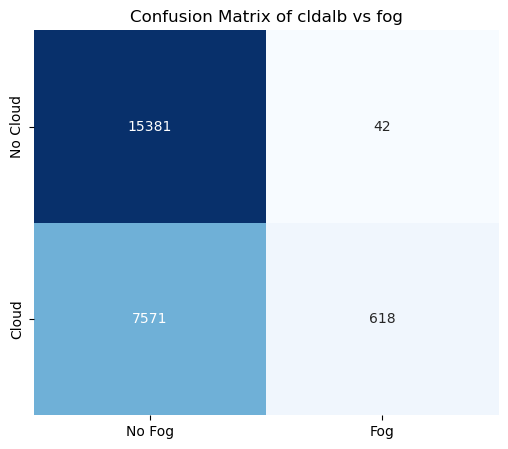

In [368]:
cm = confusion_matrix(site_df['cld-binary'], site_df['fog-binary'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs fog')

# Show the plot
plt.show()

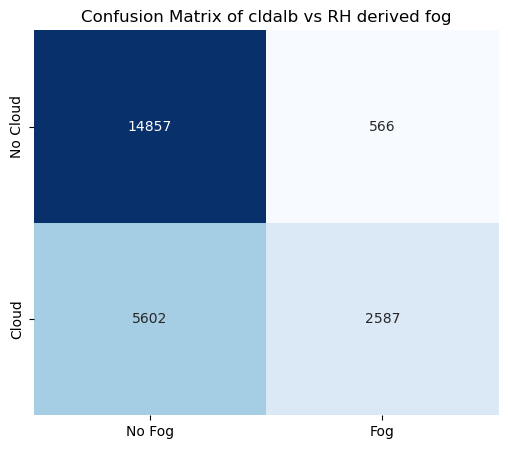

In [357]:
cm = confusion_matrix(site_df['cld-binary'], site_df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs RH derived fog')

# Show the plot
plt.show()

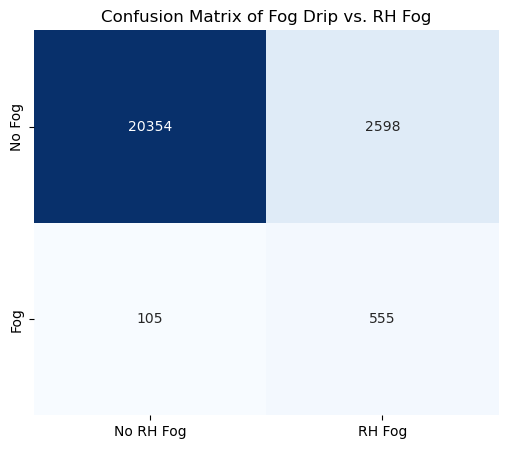

In [358]:
cm = confusion_matrix(site_df['fog-binary'], site_df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No RH Fog', 'RH Fog'], yticklabels=['No Fog', 'Fog'])

# Add labels and title
plt.title('Confusion Matrix of Fog Drip vs. RH Fog')

# Show the plot
plt.show()

## Linear Regression

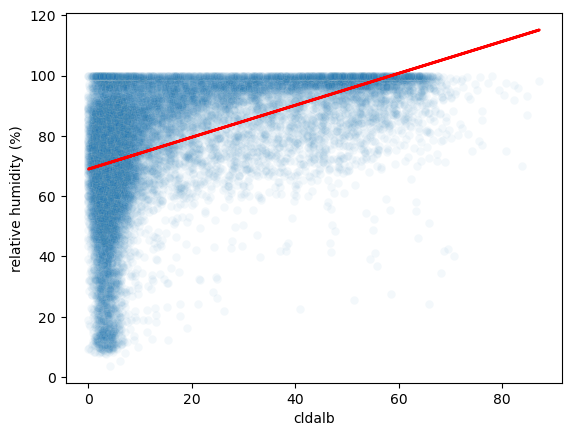

Intercept: [68.96470734]
Slope (Coefficient for cldalb): [0.52958682]
R-squared: 0.23376400334615222


In [359]:
model = LinearRegression()
model.fit(site_df[['cldalb']], site_df[['relative humidity (%)']])
y_pred = model.predict(site_df[['cldalb']])

# Create a seaborn scatterplot
sns.scatterplot(x='cldalb', y='relative humidity (%)', alpha=0.05, data=site_df)

# Plot the regression line
plt.plot(site_df['cldalb'], y_pred, color='red', linewidth=2)
plt.show()


# Get the regression results
intercept = model.intercept_
slope = model.coef_[0]  # Since we have only one feature, get the first coefficient
r_squared = model.score(site_df[['cldalb']], site_df[['relative humidity (%)']])  # R-squared value

# Print the results
print(f"Intercept: {intercept}")
print(f"Slope (Coefficient for cldalb): {slope}")
print(f"R-squared: {r_squared}")